# **EDA + A/B Testing for online store of sports goods** 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
import scipy.stats as stats
import statsmodels.stats.api as sms
from math import ceil
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('C:/Users/dasha/Desktop/product.zip', compression='zip')
df.head()

,order_id,user_id,page_id,product,site_version,time,title,target
0,cfcd208495d565ef66e7dff9f98764da,c81e728d9d4c2f636f067f89cc14862c,6f4922f45568161a8cdf4ad2299f6d23,sneakers,desktop,2019-01-11 09:24:43,banner_click,0
1,c4ca4238a0b923820dcc509a6f75849b,eccbc87e4b5ce2fe28308fd9f2a7baf3,4e732ced3463d06de0ca9a15b6153677,sneakers,desktop,2019-01-09 09:38:51,banner_show,0
2,c81e728d9d4c2f636f067f89cc14862c,eccbc87e4b5ce2fe28308fd9f2a7baf3,5c45a86277b8bf17bff6011be5cfb1b9,sports_nutrition,desktop,2019-01-09 09:12:45,banner_show,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,eccbc87e4b5ce2fe28308fd9f2a7baf3,fb339ad311d50a229e497085aad219c7,company,desktop,2019-01-03 08:58:18,banner_show,0
4,a87ff679a2f3e71d9181a67b7542122c,eccbc87e4b5ce2fe28308fd9f2a7baf3,fb339ad311d50a229e497085aad219c7,company,desktop,2019-01-03 08:59:15,banner_click,0


## info about data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8471220 entries, 0 to 8471219
Data columns (total 8 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   order_id      object
 1   user_id       object
 2   page_id       object
 3   product       object
 4   site_version  object
 5   time          object
 6   title         object
 7   target        int64 
dtypes: int64(1), object(7)
memory usage: 517.0+ MB


In [4]:
df.shape

(8471220, 8)

In [5]:
df.describe()

,target
count,8.471220e+06
mean,2.936082e-02
std,1.688158e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+00


In [6]:
df.describe(include='object')

,order_id,user_id,page_id,product,site_version,time,title
count,8471220,8471220,8471220,8471220,8471220,8471220,8471220
unique,8471220,4254619,7393316,5,2,5799549,3
top,523a4286c51e560121455fc040096ef3,6e1d9fca53a19d4f105947348fd1d627,a3d2de7675556553a5f08e4c88d2c228,clothes,mobile,2019-02-04 10:32:05,banner_show
freq,1,23,248722,1786438,6088335,10,7393314


In [7]:
print(df['title'].unique())
print(df['site_version'].unique())
print(df['product'].unique())

['banner_click' 'banner_show' 'order']
['desktop' 'mobile']
['sneakers' 'sports_nutrition' 'company' 'accessories' 'clothes']


## data cleaning

In [8]:
df.isnull().sum()
# no missing values

order_id        0
user_id         0
page_id         0
product         0
site_version    0
time            0
title           0
target          0
dtype: int64

In [9]:
duplicates_rows = df.duplicated().sum()
print(duplicates_rows)
# no duplicates

0


## change types of column + add new variables

In [10]:
df['time'] = pd.to_datetime(df['time'])

adding columns of year, month, hour, weekday

In [11]:
df['month'] = df['time'].dt.month
df['year'] = df['time'].dt.year
df['hour'] = df['time'].dt.hour
df['weekday'] = df['time'].dt.weekday + 1
df['date'] = df['time'].dt.date

In [12]:
df.head()

,order_id,user_id,page_id,product,site_version,time,title,target,month,year,hour,weekday,date
0,cfcd208495d565ef66e7dff9f98764da,c81e728d9d4c2f636f067f89cc14862c,6f4922f45568161a8cdf4ad2299f6d23,sneakers,desktop,2019-01-11 09:24:43,banner_click,0,1,2019,9,5,2019-01-11
1,c4ca4238a0b923820dcc509a6f75849b,eccbc87e4b5ce2fe28308fd9f2a7baf3,4e732ced3463d06de0ca9a15b6153677,sneakers,desktop,2019-01-09 09:38:51,banner_show,0,1,2019,9,3,2019-01-09
2,c81e728d9d4c2f636f067f89cc14862c,eccbc87e4b5ce2fe28308fd9f2a7baf3,5c45a86277b8bf17bff6011be5cfb1b9,sports_nutrition,desktop,2019-01-09 09:12:45,banner_show,0,1,2019,9,3,2019-01-09
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,eccbc87e4b5ce2fe28308fd9f2a7baf3,fb339ad311d50a229e497085aad219c7,company,desktop,2019-01-03 08:58:18,banner_show,0,1,2019,8,4,2019-01-03
4,a87ff679a2f3e71d9181a67b7542122c,eccbc87e4b5ce2fe28308fd9f2a7baf3,fb339ad311d50a229e497085aad219c7,company,desktop,2019-01-03 08:59:15,banner_click,0,1,2019,8,4,2019-01-03


Changing types of column to category

In [13]:
df['product'] = df['product'].astype('category')
df['site_version'] = df['site_version'].astype('category')
df['title'] = df['title'].astype('category')
df['target'] = df['target'].astype('category')

## descriptive statistics

In [14]:
df.describe()

,time,month,year,hour,weekday
count,8471220,8.471220e+06,8471220.0,8.471220e+06,8.471220e+06
mean,2019-03-24 09:10:43.288166400,3.239505e+00,2019.0,1.236124e+01,3.986464e+00
min,2019-01-01 00:00:03,1.000000e+00,2019.0,0.000000e+00,1.000000e+00
25%,2019-02-15 12:19:35.500000,2.000000e+00,2019.0,8.000000e+00,2.000000e+00
50%,2019-03-29 15:16:19.500000,3.000000e+00,2019.0,1.200000e+01,4.000000e+00
75%,2019-05-01 07:23:01,5.000000e+00,2019.0,1.700000e+01,6.000000e+00
max,2019-05-31 23:59:58,5.000000e+00,2019.0,2.300000e+01,7.000000e+00
std,NaN,1.421114e+00,0.0,5.422469e+00,1.989171e+00


In [15]:
df.describe(include='category')

,product,site_version,title,target
count,8471220,8471220,8471220,8471220
unique,5,2,3,2
top,clothes,mobile,banner_show,0
freq,1786438,6088335,7393314,8222498


### category variables

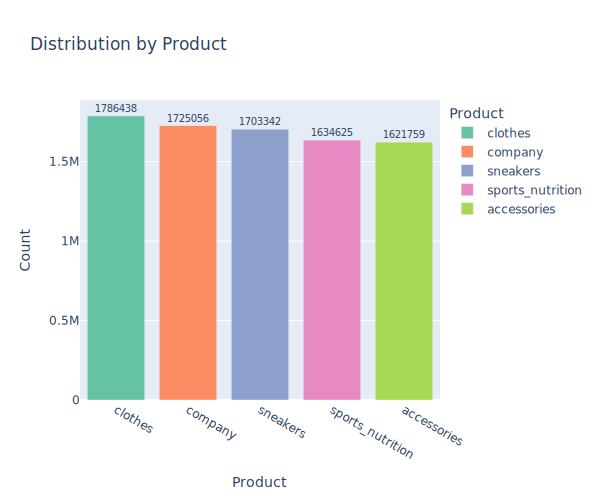

In [58]:
counts = df['product'].value_counts().reset_index()
counts.columns = ['product', 'count']

fig = px.bar(counts, x='product', y='count', 
             title='Distribution by Product',
             labels={'product': 'Product', 'count': 'Count'},
             color='product', 
             color_discrete_sequence=px.colors.qualitative.Set2,
             width=600, 
             height=500)  

for index, row in counts.iterrows():
    fig.add_annotation(x=row['product'], 
                       y=row['count'] + 50000,  # отступ над столбцом
                       text=str(row['count']),
                       showarrow=False,
                       font=dict(size=10),
                       align='center')
fig.show('svg')

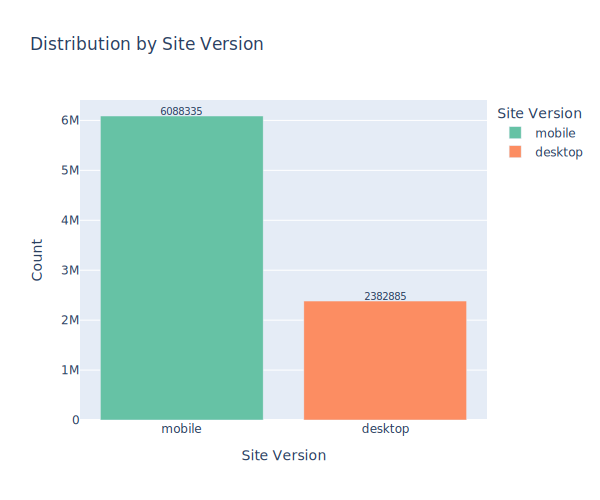

In [59]:
counts = df['site_version'].value_counts().reset_index()
counts.columns = ['site_version', 'count']

fig = px.bar(counts, x='site_version', y='count', 
             title='Distribution by Site Version',
             labels={'site_version': 'Site Version', 'count': 'Count'},
             color='site_version', 
             color_discrete_sequence=px.colors.qualitative.Set2,
             width=600, 
             height=500)  

for index, row in counts.iterrows():
    fig.add_annotation(x=row['site_version'], 
                       y=row['count'] + 100000,  # отступ над столбцом
                       text=str(row['count']),
                       showarrow=False,
                       font=dict(size=10),
                       align='center')
fig.show('svg')

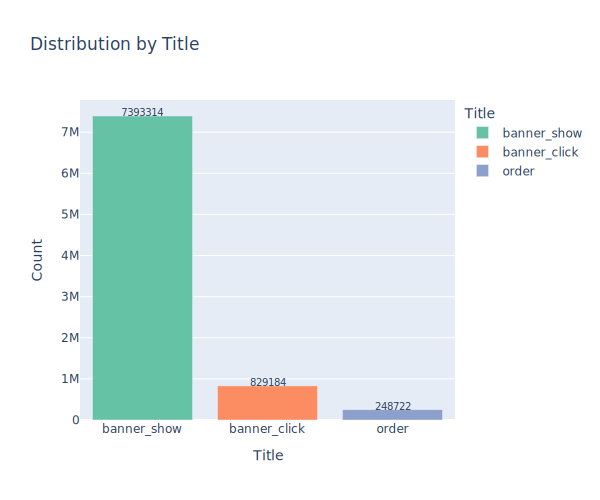

In [60]:
counts = df['title'].value_counts().reset_index()
counts.columns = ['title', 'count']

fig = px.bar(counts, x='title', y='count', 
             title='Distribution by Title',
             labels={'title': 'Title', 'count': 'Count'},
             color='title', 
             color_discrete_sequence=px.colors.qualitative.Set2,
             width=600, 
             height=500)  

for index, row in counts.iterrows():
    fig.add_annotation(x=row['title'], 
                       y=row['count'] + 100000,  # отступ над столбцом
                       text=str(row['count']),
                       showarrow=False,
                       font=dict(size=10),
                       align='center')
fig.show('svg')

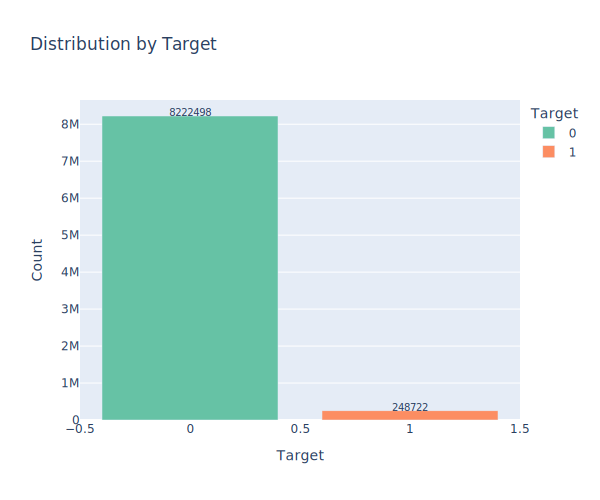

In [61]:
counts = df['target'].value_counts().reset_index()
counts.columns = ['target', 'count']

fig = px.bar(counts, x='target', y='count', 
             title='Distribution by Target',
             labels={'target': 'Target', 'count': 'Count'},
             color='target', 
             color_discrete_sequence=px.colors.qualitative.Set2,
             width=600, 
             height=500)  

for index, row in counts.iterrows():
    fig.add_annotation(x=row['target'], 
                       y=row['count'] + 100000,  # отступ над столбцом
                       text=str(row['count']),
                       showarrow=False,
                       font=dict(size=10),
                       align='center')
fig.show('svg')

Target variable with 1 has the same number of rows as a title with order parameter.

In [20]:
pd.crosstab(df.title, df.target)

target,0,1
title,,
banner_click,829184,0
banner_show,7393314,0
order,0,248722


We see that target variable equals 1 tells that users made an order, while target variable equals 0 contains only actions like banner show or banner click.

### numeric variables

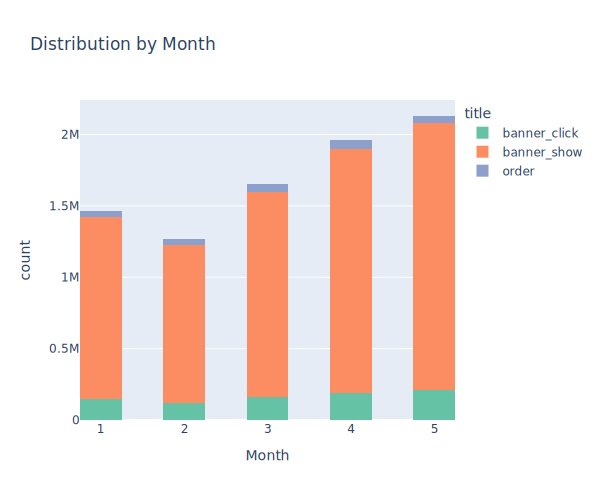

In [64]:
fig = px.histogram(df, x='month', color= 'title',
                   title='Distribution by Month',
                   labels={'month': 'Month', 'count': 'Count'},
                   nbins=10,
                   color_discrete_sequence=px.colors.qualitative.Set2,
                   width=600, height=500)
fig.show('svg')

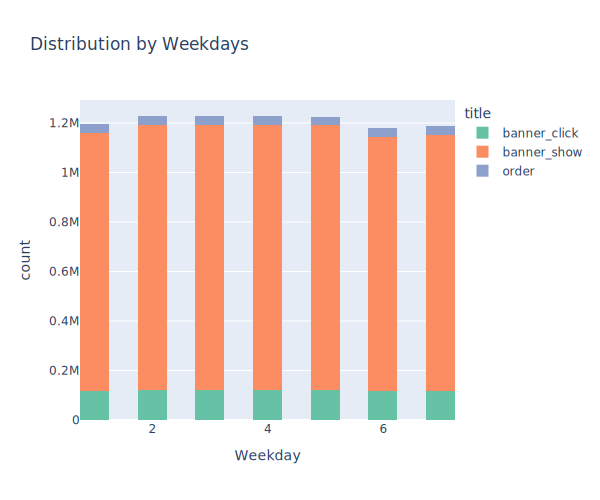

In [65]:
fig = px.histogram(df, x='weekday', color= 'title',
                   title='Distribution by Weekdays',
                   labels={'weekday': 'Weekday', 'count': 'Count'},
                   nbins=30,
                   color_discrete_sequence=px.colors.qualitative.Set2,
                   width=600, height=500)
fig.show('svg')

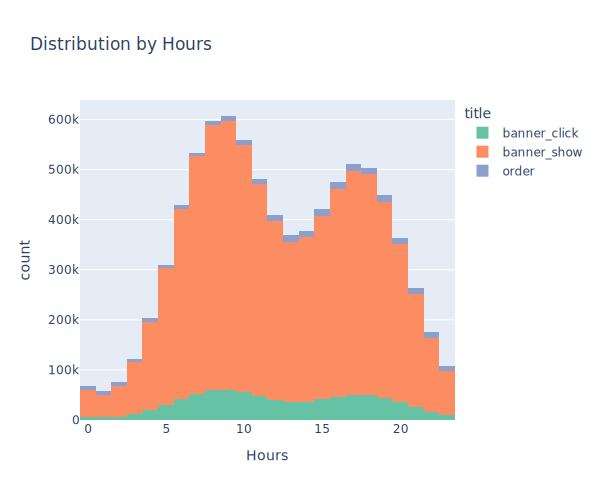

In [66]:
fig = px.histogram(df, x='hour', color= 'title',
                   title='Distribution by Hours',
                   labels={'hour': 'Hours', 'count': 'Count'},
                   nbins=24,
                   color_discrete_sequence=px.colors.qualitative.Set2,
                   width=600, height=500)
fig.show('svg')

# **Conversions and seasonality**

In [24]:
conversion = df.groupby('title').user_id.nunique().reset_index().sort_values('user_id', ascending = False)
conversion

,title,user_id
1,banner_show,4254618
0,banner_click,742458
2,order,237866


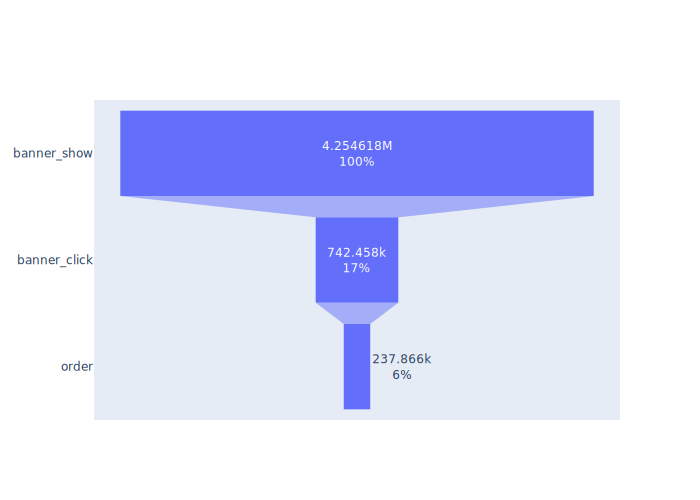

In [25]:
fig = go.Figure(go.Funnel(x = conversion['user_id'],
                          y = conversion['title'],
                           textinfo = "value+percent initial"))
fig.show('svg')

General conversion for two site versions is 6%.

In [26]:
df_season = df.groupby('date').title.value_counts().reset_index(name='count')

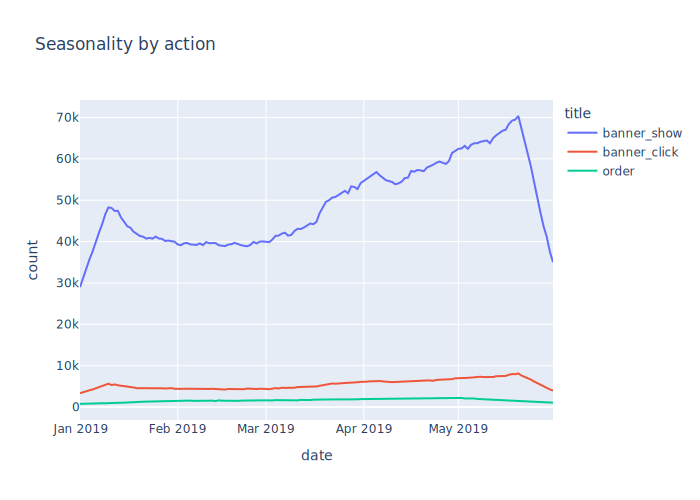

In [27]:
fig = px.line(df_season, x = 'date', y = 'count', color = 'title', title='Seasonality by action')
fig.show('svg')

Order line is quite stable during the period, moreover, it does not fluctuate, when banner show increase.

## **Desktop version conversion**

In [28]:
df_desktop = df[df['site_version'] == 'desktop']
conversion_desk = df_desktop.groupby('title').user_id.nunique().reset_index().sort_values('user_id', ascending = False)
conversion_desk

,title,user_id
1,banner_show,1424771
2,order,125404
0,banner_click,111334


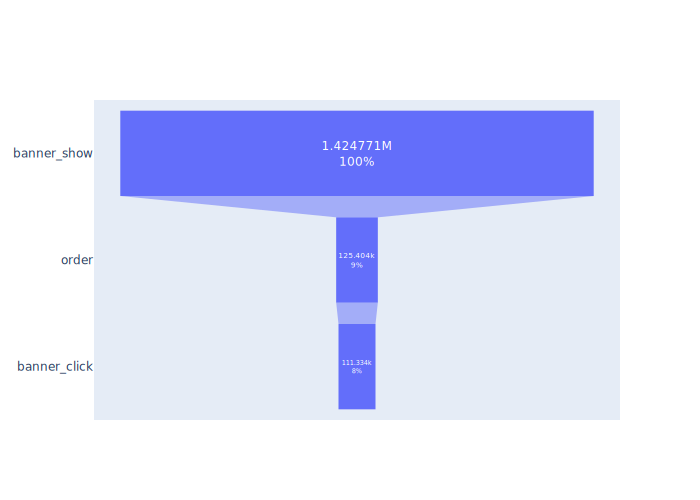

In [29]:
fig = go.Figure(go.Funnel(x = conversion_desk['user_id'],
                          y = conversion_desk['title'],
                           textinfo = "value+percent initial"))
fig.show('svg')

Desktop order conversion 9%. Users tend to make purchases by own needs without additional marketing interaction in form of banners.

In [30]:
df_desktop_season = df_desktop.groupby('date').title.value_counts().reset_index(name='count')

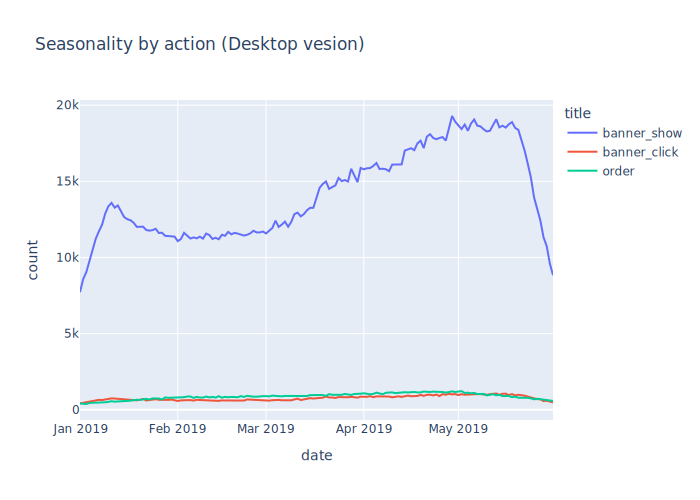

In [31]:
fig = px.line(df_desktop_season, x = 'date', y = 'count', color = 'title', title='Seasonality by action (Desktop vesion)')
fig.show('svg')

## **Mobile version conversion**

In [32]:
df_mobile = df[df['site_version'] == 'mobile']
conversion_mob = df_mobile.groupby('title').user_id.nunique().reset_index().sort_values('user_id', ascending = False)
conversion_mob

,title,user_id
1,banner_show,2857187
0,banner_click,631644
2,order,112574


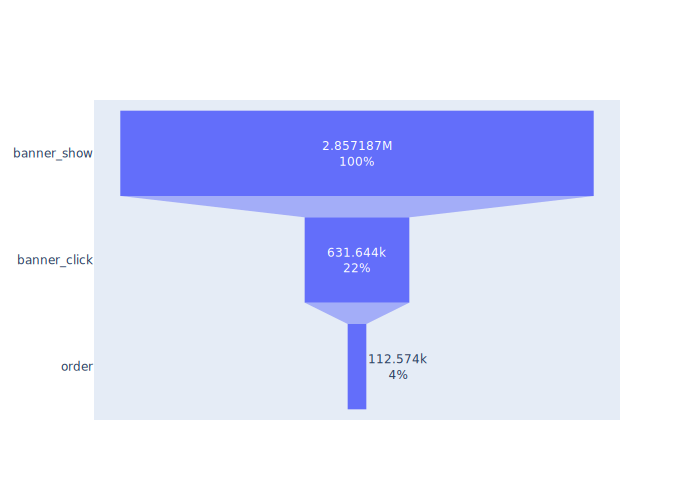

In [33]:
fig = go.Figure(go.Funnel(x = conversion_mob['user_id'],
                          y = conversion_mob['title'],
                           textinfo = "value+percent initial"))
fig.show('svg')

Mobile version order conversion is noticeably lower than desktop - 4%, probably there are some inconveniences for making purchases in the mobile version.

In [34]:
df_mobile_season = df_mobile.groupby('date').title.value_counts().reset_index(name='count')

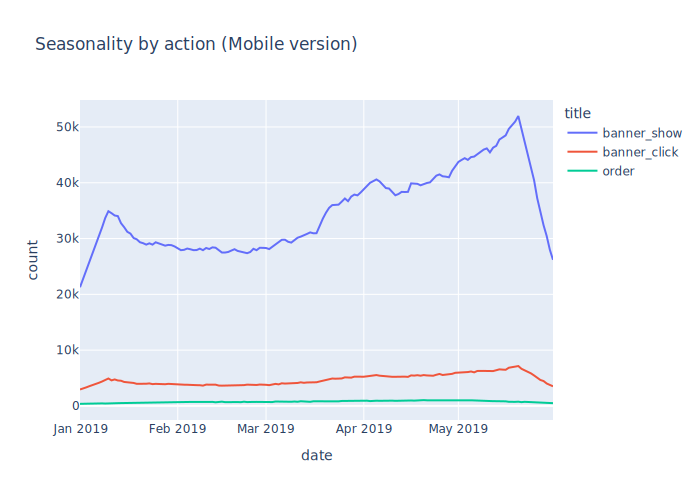

In [35]:
fig = px.line(df_mobile_season, x = 'date', y = 'count', color = 'title', title='Seasonality by action (Mobile version)')
fig.show('svg')

# **A/B Testing**

**Hypotheses**:

**H0**: Using the desktop or mobile versions of the site equally affects the user's decision to make an order.  
**H1**: Using the desktop or mobile versions of the site not equally affects the user's decision to make an order.

In [36]:
pd.crosstab(df.target, df.site_version, normalize="columns")

site_version,desktop,mobile
target,,
0,0.944109,0.981023
1,0.055891,0.018977


In [73]:
pd.crosstab(df.title, df.site_version, normalize="columns")

site_version,desktop,mobile
title,,
banner_click,0.048288,0.117293
banner_show,0.895821,0.863730
order,0.055891,0.018977


In [74]:
# Sample size
effect_size = sms.proportion_effectsize(0.06,0.02) 

required_n = sms.NormalIndPower().solve_power(
    effect_size, power = 1, alpha = 0.05, ratio = 1)

required_n = ceil(required_n)
print(required_n) 

5000


In [75]:
desk = df_desktop.sample(n=required_n, random_state = 123)
mob = df_mobile.sample(n=required_n, random_state = 123)

In [76]:
ab_testing_sample = pd.concat([desk, mob], axis = 0)
ab_testing_sample.reset_index(drop=True, inplace=True)

In [77]:
ab_testing_sample['target'] = ab_testing_sample['target'].astype(int)

In [78]:
conversion_ = ab_testing_sample.groupby('site_version')['target']

std_ = lambda x : np.std(x,ddof=0)
se_ = lambda x : stats.sem(x,ddof=0)

conversion_ = conversion_.agg([np.mean,std_,se_])
conversion_.columns = ['conversion_rate','standard_deviation','standard_error']
conversion_.round(decimals=3)

,conversion_rate,standard_deviation,standard_error
site_version,,,
desktop,0.058,0.233,0.003
mobile,0.018,0.132,0.002


In [79]:
conversion_ = conversion_.reset_index()

# Способ 2: переименование индекса
conversion_.index.name = 'Site Version'

conversion_

,site_version,conversion_rate,standard_deviation,standard_error
Site Version,,,,
0,desktop,0.0578,0.233365,0.00330
1,mobile,0.0178,0.132224,0.00187


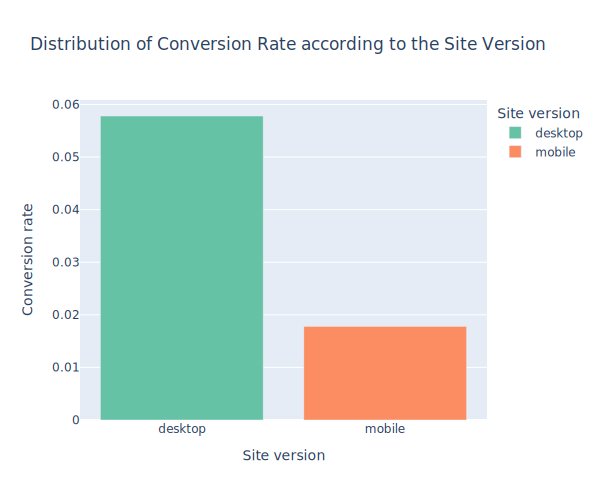

In [80]:
fig = px.bar(conversion_, x='site_version', y='conversion_rate', 
             title='Distribution of Conversion Rate according to the Site Version',
             labels={'site_version': 'Site version', 'conversion_rate': 'Conversion rate'},
             color='site_version', 
             color_discrete_sequence=px.colors.qualitative.Set2,
             width=600, 
             height=500)  
fig.show('svg')

In [81]:
desk_test_result = ab_testing_sample[ab_testing_sample['site_version'] == 'desktop']['target']
mob_test_result = ab_testing_sample[ab_testing_sample['site_version'] == 'mobile']['target']


successes = [desk_test_result.sum(), mob_test_result.sum()]
nobs = [desk_test_result.count(),mob_test_result.count()]

z_stat, p_val = proportions_ztest(successes, nobs = nobs)

In [82]:
print(f'Z-Stats : {z_stat:.3f}')
print(f'P-Value : {p_val:.3f}')

Z-Stats : 10.487
P-Value : 0.000


In [83]:
(low_d, low_m), (up_d,up_m) = proportion_confint(successes, nobs=nobs, alpha = 0.05)

In [85]:
print(f'Confidence interval 95% value for desktop veriom: [{low_d:.3f},{up_d:.3f}]')
print(f'Confidence interval 95% value for mobile version: [{low_m:.3f},{up_m:.3f}]')

Confidence interval 95% value for desktop veriom: [0.051,0.064]
Confidence interval 95% value for mobile version: [0.014,0.021]


P-value < 0.05, therefore we reject the null hypothesis (H0) and accept alternative (H1) - "Using the desktop or mobile versions of the site not equally affects the user's decision to make an order".